In [16]:
import sys # for automation and parallelization: set manual to false when run by a launcher
import json
 
default = {'scenario': 'houston','project':'port-moresby','training_folder':'../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))


In [17]:
import os
import time
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans
from shapely.geometry import Point
import sys
import networkx as nx
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.engine.road_model import RoadModel, plot_correlation, plot_random_od

In [18]:
def create_zones_from_nodes(nodes,num_zones=100):
    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)
    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)
    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')
    cluster.fit(nodes[['x','y']].values)
    geom = [Point(val) for val in cluster.cluster_centers_]
    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)
    zones.index = 'zone_' + zones.index.astype(str)
    return zones

def main_strongly_connected_component(links, nodes=None, split_direction=False):
    graph = nx.DiGraph()
    graph.add_edges_from(links[['a', 'b']].values.tolist())
    if 'oneway' in links.columns and split_direction :
        graph.add_edges_from(
            links.loc[~links['oneway'].astype(bool)][['b', 'a']].values.tolist()
        )

    main_scc = None
    size = 0
    for scc in nx.strongly_connected_components(graph):
        if len(scc) > size :
            size = len(scc)
            main_scc = scc

    l = links.loc[links['a'].isin(main_scc) & links['b'].isin(main_scc)]
    if nodes is not None:
        n = nodes.loc[list(main_scc)]
        return l, n
    return l 


In [19]:
scenario = argv['scenario']
project = argv['project']

on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
print('On Lambda : ', on_lambda)

training_folder = argv['training_folder']
input_folder = training_folder +r'/inputs/'

if not on_lambda:
    scenario_folder = training_folder + '/scenarios/' + project + '/inputs/'
    output_folder = training_folder + '/scenarios/' + project + '/outputs/'
    model_folder = training_folder + '/scenarios/' + project + '/model/'
else:
    scenario_folder = input_folder
    output_folder = training_folder + '/outputs/'
    model_folder = training_folder + '/model/'
print('input folder: ', input_folder)
print('output folder: ', output_folder)
print('scen folder : ', scenario_folder)
print('model folder : ', model_folder)

On Lambda :  False
input folder:  ../../inputs/
output folder:  ../../scenarios/port-moresby/outputs/
scen folder :  ../../scenarios/port-moresby/inputs/
model folder :  ../../scenarios/port-moresby/model/


In [20]:
num_zones = 500
train_size = 2500
date_time = '2022-12-13T08:00:21+10:00'
ff_time_col = 'time'
max_speed = 100
num_cores = 4
hereApiKey= ''   

In [21]:
input_folder

'../../inputs/'

# read files

In [22]:
links = gpd.read_file(input_folder + '{}/road/road_links.geojson'.format(scenario),engine='pyogrio')
links.set_index('index',inplace=True)
nodes = gpd.read_file(input_folder + '{}/road/road_nodes.geojson'.format(scenario),engine='pyogrio')
nodes.set_index('index',inplace=True)

In [23]:
zones = create_zones_from_nodes(nodes,num_zones=num_zones)

In [24]:
self = RoadModel(links,nodes,zones,ff_time_col=ff_time_col)

In [25]:
self.split_quenedi_rlinks()

In [26]:
len(self.road_links)

23125

In [27]:
self.road_links,self.road_nodes=main_strongly_connected_component(self.road_links,self.road_nodes)

In [28]:
#remove NaN time. use 20kmh
print(len(self.road_links[self.road_links[self.ff_time_col].isnull()]),'links with null time. replace with 20kmh time')
self.road_links.loc[self.road_links[self.ff_time_col].isnull(),self.ff_time_col] = self.road_links.loc[self.road_links[self.ff_time_col].isnull(),'length']*3.6/20

3529 links with null time. replace with 20kmh time


In [29]:
self.zones_nearest_node()
self.create_od_mat()

max_distance found:  0.004621339551469983 degrees


/home/robitaille/Quetzal/quetzal_classic/notebooks/1_preparation/../../../quetzal/quetzal/engine/road_model.py:128: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid['geometry'] = centroid.centroid


In [30]:
print(len(self.od_time),'OD')
print(len(self.zones_centroid), 'zones')

249500 OD
500 zones


In [31]:
train_od = self.get_training_set(train_size=train_size,seed=42)

reset origins
reset destinations
5.0
100 blocks of 5.0 origins, 2500 ODs


In [32]:

#read Here matrix
try:
    mat = pd.read_csv(input_folder + '{}_road/here_OD.csv'.format(scenario))
    mat = mat.set_index('origin')
    mat.columns.name='destination'
except:
    mat = self.call_api_on_training_set(train_od,
                                         apiKey=hereApiKey,
                                         api='here',
                                         mode='car',
                                         time=date_time,
                                         saving=False)
    mat.to_csv(input_folder + 'here_OD.csv')

0 / 100


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

20 / 100


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

errors [[4 4 4 4 4]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
times [[-9999 -9999 -9999 -9999 -9999]
 [ 1731  1357  1362  1336  1481]
 [  743   814   286  1235   377]
 [ 1807  1433  1438  1412  1557]
 [ 1522  1148  1153  1127  1272]]


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

40 / 100


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


errors [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]
times [[  577  1169  1315 -9999   607]
 [  292  1502   929 -9999  1035]
 [  770   820  1508 -9999   665]
 [ 1098  1690  1836 -9999  1128]
 [  435  1433  1173 -9999   966]]


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

60 / 100


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

errors [[4 4 4 4 4]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
times [[-9999 -9999 -9999 -9999 -9999]
 [  976   988   671  1183  1010]
 [ 1921  1933  1616  2128  1955]
 [ 1156  1168   756  1268  1190]
 [ 1702  1714  1397  1909  1736]]


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

errors [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]
times [[  682  1691  1768 -9999   800]
 [ 1032  1314  2234 -9999  1150]
 [  873  1282  2075 -9999   991]
 [  885  2337  1172 -9999  1098]
 [  609  1465  1811 -9999   727]]


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

errors [[0 0 0 0 0]
 [0 0 0 0 0]
 [4 4 4 4 4]
 [0 0 0 0 0]
 [0 0 0 0 0]]
times [[  943  1500  1699  1136  1521]
 [ 1414   115  1457   989  1374]
 [-9999 -9999 -9999 -9999 -9999]
 [  875   690   989   521   857]
 [ 1029  1006  1007   380   500]]


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


80 / 100


/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'matrix.router.hereapi.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

In [33]:
self.apply_api_matrix(mat,api_time_col='here_time')

25 unfound OD in the api call, they will be interpolated
od time applied on 2475
od to interpolate 247025


In [34]:
self.train_knn_model(weight='distance', n_neighbors=5)
self.predict_zones()

In [35]:
100/len(links)

0.008054123711340205

In [36]:
err = self.apply_od_time_on_road_links(gap_limit=0.5,max_num_it=10, num_cores=num_cores, max_speed=max_speed,log_error=True)


0 14.63
1 2.97
2 2.58
3 2.37
4 2.26
5 2.19
6 2.15
7 2.12
8 2.09
9 2.07
10 2.06
43.5 % of links used


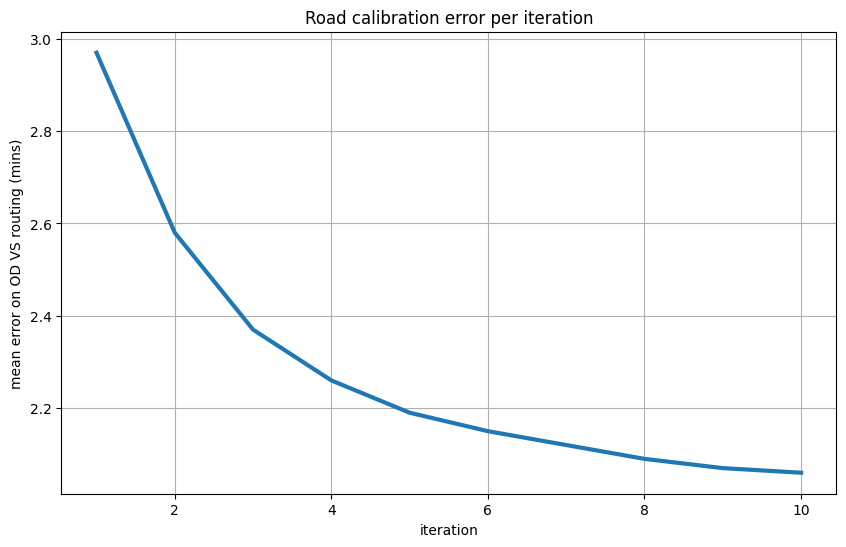

In [37]:
import matplotlib.pyplot as plt
if True:
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot([x[0] for x in err[1:]],[x[1] for x in err[1:]],linewidth=3)
    plt.grid(True, 'major', linestyle='-', axis='both')
    ax.set_axisbelow(True)
    plt.xlabel('iteration')
    plt.title('Road calibration error per iteration')
    plt.ylabel('mean error on OD VS routing (mins)')
    #plt.savefig(figdir +'/error.png')

In [38]:
from io import BytesIO

Mean Absolute Error: 2.06 mins.


0

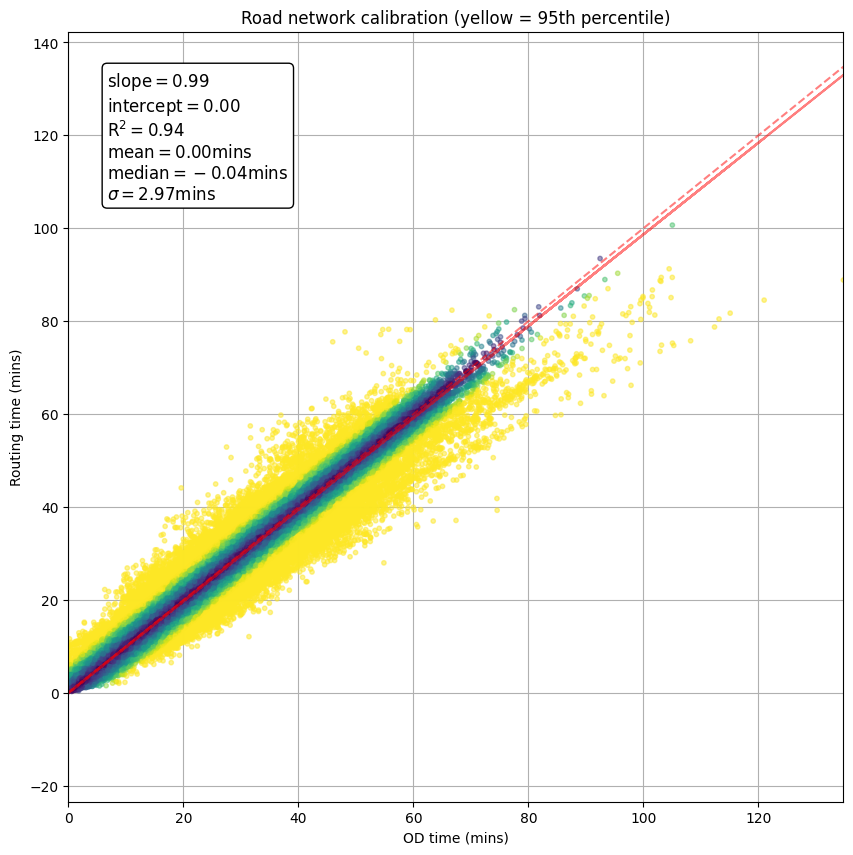

In [39]:
img_data = BytesIO()
plot_correlation(self.od_time['here_time']/60, 
                 self.od_time['routing_time']/60, 
                 alpha=0.5,
                 xlabel='OD time (mins)', 
                 ylabel='Routing time (mins)',
                 title = 'Road network calibration (yellow = 95th percentile)')
plt.savefig(img_data, format='png')
img_data.seek(0)

In [40]:
self.merge_quenedi_rlinks()

In [41]:
%matplotlib inline

In [42]:
from syspy.spatial.spatial import plot_lineStrings

Text(0.5, 1.0, 'Zones Centroids')

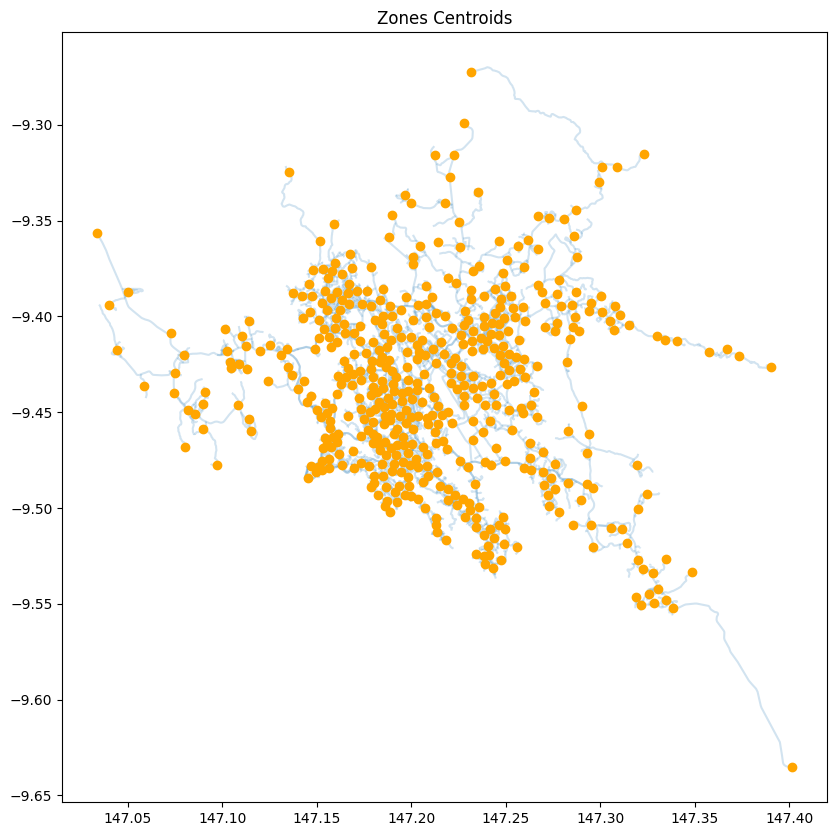

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
plot_lineStrings(self.road_links, ax=ax, alpha=0.2, zorder=1)
self.zones_centroid.plot(ax=ax,color='orange',zorder=2)
plt.title('Zones Centroids')
#plt.savefig(figdir +'/zones.png')

/home/robitaille/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


CPU times: user 1.9 s, sys: 340 ms, total: 2.24 s
Wall time: 1.86 s


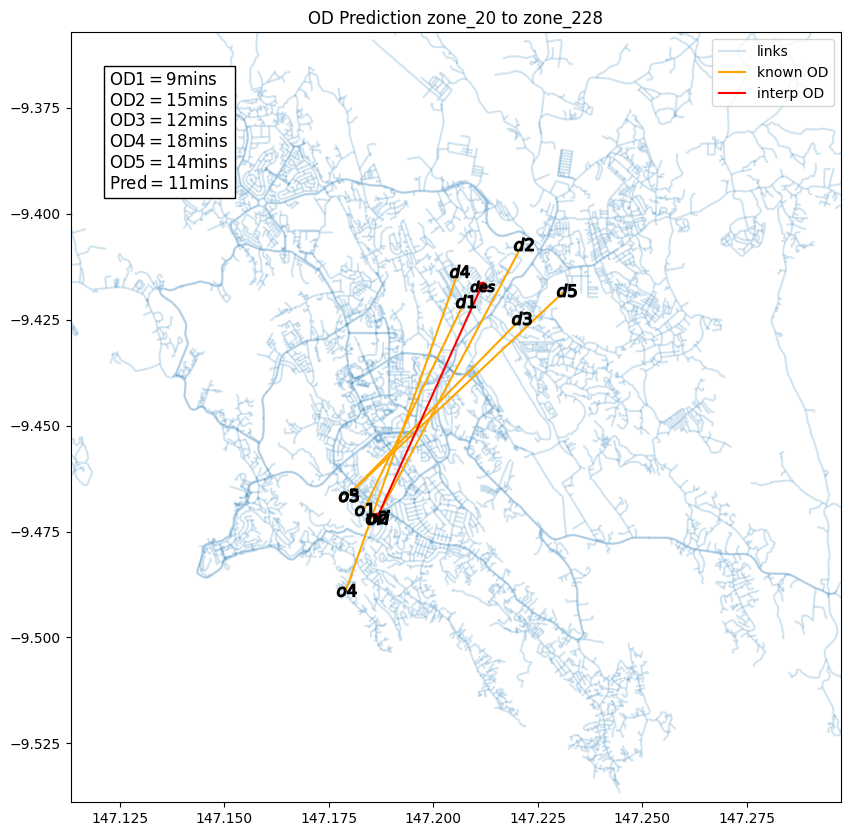

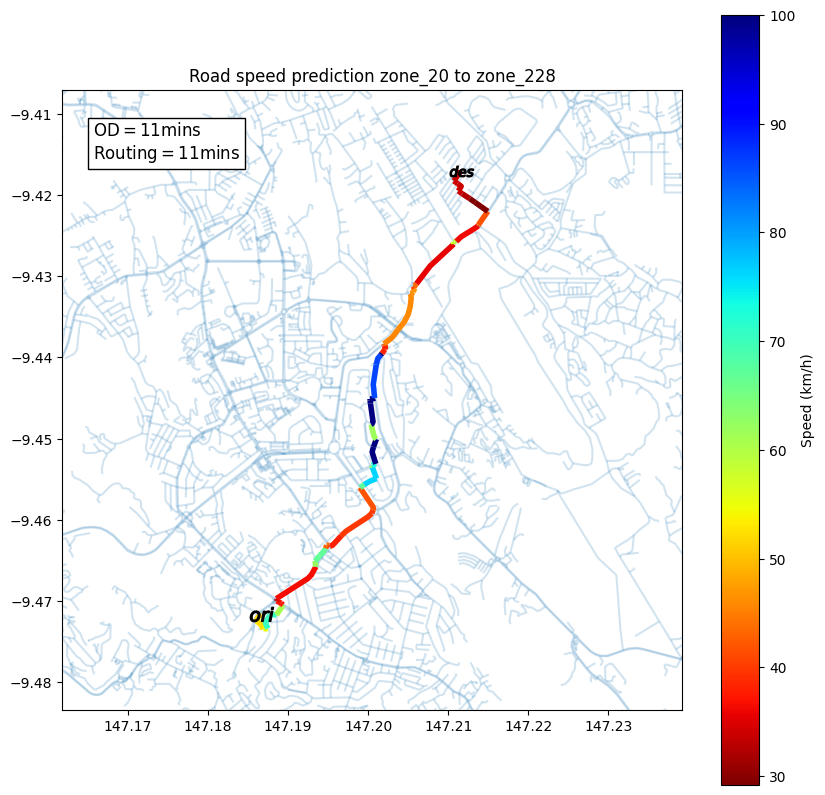

In [44]:
%%time
f,f2=plot_random_od(self,43)

ValueError: array must not contain infs or NaNs

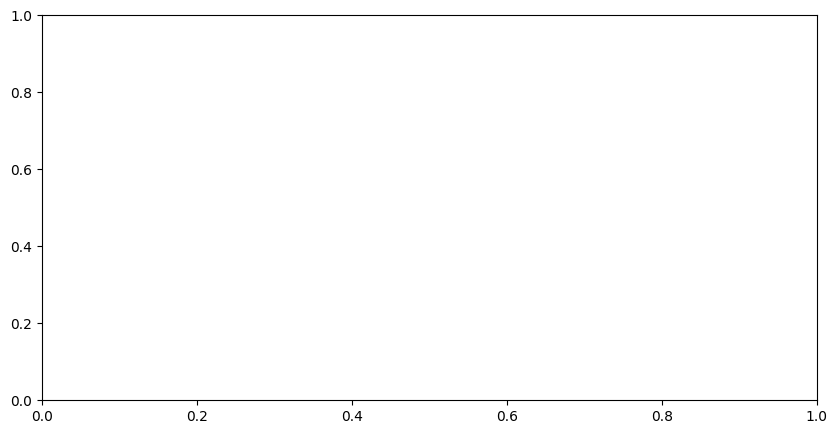

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
import numpy as np
import scipy.stats as stats
x=np.linspace(0, 100, 500)
density = stats.gaussian_kde(self.road_links['speed'])
plt.plot(x,density(x))
density = stats.gaussian_kde(self.road_links[np.isfinite(self.road_links['here_speed'])]['here_speed'])
plt.plot(x,density(x))
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,100])
plt.legend(['speed_ff', 'speed'])
plt.xlabel('speed (km/h)')
plt.ylabel('density')

plt.title('Speed on road')
plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=(10,10))
#self.road_links.plot(ax=ax,column='here_speed',legend=True,linewidth=2,cmap='jet_r')
#plt.title('Speed (km/h)')


In [46]:
self.road_links.to_file(scenario_folder + 'road/road_links.geojson',engine='pyogrio',driver='GeoJSON')
self.road_nodes.to_file(scenario_folder + 'road/road_nodes.geojson',engine='pyogrio',driver='GeoJSON')

# Model calibration

In [47]:
import random
import numpy as np
seed = 43
validation_percent = 10  # percent of data to test on

In [48]:
test = self.copy()
test.od_time = test.od_time[test.od_time['interpolated']==False]
test.od_time = test.od_time.reset_index(drop=True)
test.od_time['api_time'] = test.od_time['here_time'].copy()
random.seed(seed)
randindex = [random.randint(0,len(test.od_time)-1) for i in range(round(len(test.od_time)*validation_percent/10))]

test.od_time.loc[randindex,'here_time'] = np.nan
test.od_time.loc[randindex,'interpolated'] = True

test.train_knn_model(weight='distance', n_neighbors=5)
test.predict_zones()

test.od_time = test.od_time[test.od_time['interpolated']]

Mean Absolute Error: 3.7 mins.


0

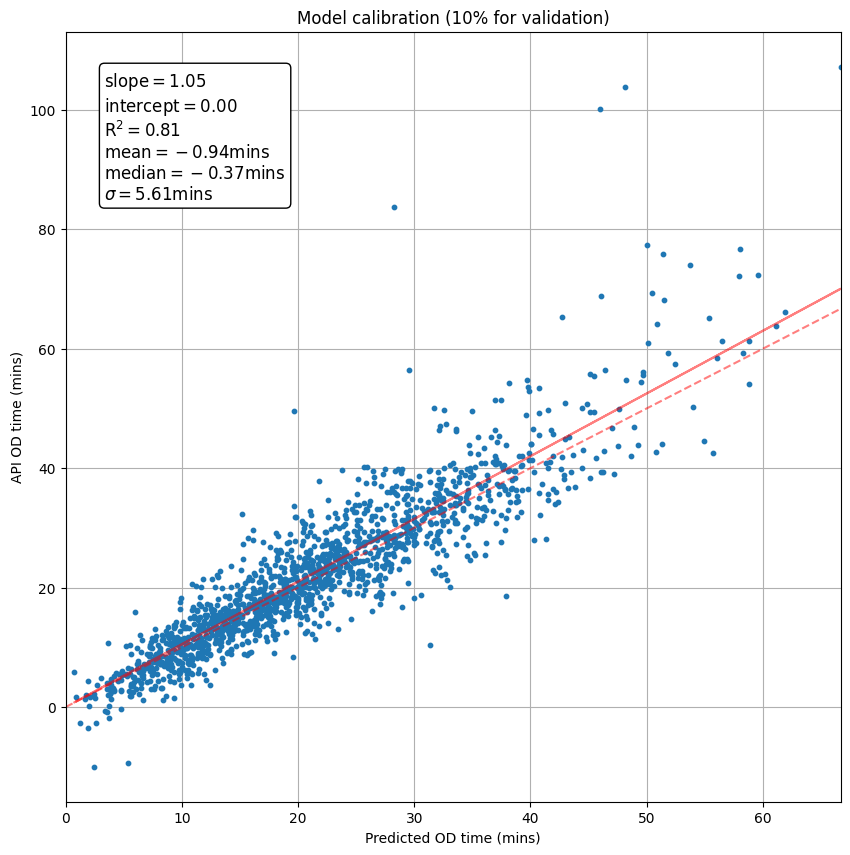

In [49]:
img_data = BytesIO()
plot_correlation(test.od_time['api_time']/60, 
                 test.od_time['here_time']/60, 
                 colors=False,
                 alpha=1,
                 xlabel='Predicted OD time (mins)', 
                 ylabel='API OD time (mins)',
                 title = f'Model calibration ({validation_percent}% for validation)')
plt.savefig(img_data, format='png')
img_data.seek(0)